In [2]:
from datascience import Table
import csv
import numpy as np

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')


# Data-driven Analysis of NBA Draft Adages
---
## Objective
---
Every year, the teams in the NBA draft amateur players with the hope that they will become future star players. Over the years, many widely held assumptions have formed about which types of players to draft. This project will take a closer statistical look at these adages and try to conclude if they are legitimate or merely myth.



More specifically, here are the adages I explored:
- The Spurs consistently draft players who exceed their expectations
- Big men who are too skinny as prospects are more likely to fail
- Big men have shorter careers

## Data
---
I collected data from two main sources.

1) I downloaded all draft data from Basketball Reference from the years 1990-2015. An appropriate subset will be used for each analysis. 
2) stats.nba.com has a wealth of NBA Combine measurements. This anthropometric data is at the core of some of these draft adages. 

The `draft_data` table includes summary statistics on all drafted players that do a good job describing how a player has performed over their career.

The `anthro_data` table includes measurements of NBA prospects taken pre-draft, including height, weight, body fat percentage, wingspan, standing reach, etc.

In [3]:
draft_data = None

for i in range(1991, 2016):
    with open('data/drafts/draft_NBA_' + str(i) + '_stats.csv', 'rt', encoding='ascii') as f:
        reader = csv.reader(f)
        j = 0
        for row in reader:
            
            if j == 0 and i == 1991:
                row[14] = 'MPPG'
                row[14] = 'MPPG'
                row[15] = 'PPG'
                row[16] = 'RPG'
                row[17] = 'APG'
                draft_data = Table(['Year'] + row)
                
            elif j != 0:
                draft_data = draft_data.with_row([str(i)] + row)
            j += 1
            
anthro_data = None

for i in range(2000, 2012):
    with open('data/combines/anthro_' + str(i) + '.csv', 'rt', encoding='ascii') as f:
        reader = csv.reader(f)
        j = 0
        for row in reader:
            if j == 0 and i == 2000:
                anthro_data = Table(['Year'] + row)
            else:
                if row[5] != 'POSITION':
                    anthro_data = anthro_data.with_row([str(i)] + row)
                else:
                    j-=1
            j += 1



In [4]:
draft_data.where('Player', 'Tim Duncan').show(2)

Year,Rk,Pk,Tm,Player,College,Yrs,G,MP,PTS,TRB,AST,FG%,3P%,FT%,MPPG,PPG,RPG,APG,WS,WS/48,BPM,VORP
1997,1,1,SAS,Tim Duncan,Wake Forest University,19,1392,47368,26496,15091,4225,.506,.179,.696,34.0,19.0,10.8,3.0,206.4,.209,5.5,89.3


In [5]:
anthro_data.show(2)

Year,TEMP_PLAYER_ID,PLAYER_ID,FIRST_NAME,LAST_NAME,PLAYER_NAME,POSITION,HEIGHT_WO_SHOES,HEIGHT_WO_SHOES_FT_IN,HEIGHT_W_SHOES,HEIGHT_W_SHOES_FT_IN,WEIGHT,WINGSPAN,WINGSPAN_FT_IN,STANDING_REACH,STANDING_REACH_FT_IN,BODY_FAT_PCT,HAND_LENGTH,HAND_WIDTH
2000,,2124,Malik,Allen,Malik Allen,PF-C,80.25,6' 8.25'',,,271,86.5,7' 2.5'',109.0,9' 1'',,,
2000,,12019,Harold,Arceneaux,Harold Arceneaux,SG-SF,76.5,6' 4.5'',,,219,80.5,6' 8.5'',103.0,8' 7'',,,


## Exploration
---
This section is a primer for the testing of the adages. It shows how the data can be queried and visualized. 


Anthropometric data is pretty important. Perhaps we'd like to see the average 'size' of players at each position. 

In [6]:
anthro_data = anthro_data.where(anthro_data.column("HEIGHT_WO_SHOES") != "")
anthro_data['BMI'] = np.divide(anthro_data.apply(lambda x: float(x),'WEIGHT'), \
                    (anthro_data.apply(lambda x: float(x)*float(x),'HEIGHT_WO_SHOES')))*703


### Attributes by Position
---
What does an incoming NBA Center look like?

In [7]:
centers = anthro_data.where("POSITION", "C")
centers = centers.select(['HEIGHT_WO_SHOES', 'WEIGHT', 'WINGSPAN', 'STANDING_REACH'])

sr = centers.column('STANDING_REACH')
temp = centers.where(centers.column('STANDING_REACH') != '') 
ratio = np.mean(temp.column('STANDING_REACH').astype(np.float) / temp.column('HEIGHT_WO_SHOES').astype(np.float))
sr[sr == ''] = ratio * 82.5
centers['STANDING_REACH'] = sr.astype(np.float)

print('An incoming NBA Center is on average ' + \
      str(np.mean(centers.column(0).astype(np.float))) + ' inches tall.')
print('An incoming NBA Center is on average ' + \
      str(np.mean(centers.column(1).astype(np.float))) + ' pounds heavy.')
print('An incoming NBA Center has on average a ' + \
      str(np.mean(centers.column(2).astype(np.float))) + ' inch wingspan.')
print('An incoming NBA Center has on average a ' + \
      str(np.mean(centers.column(3).astype(np.float))) + ' inch standing reach.')

An incoming NBA Center is on average 82.7318181818 inches tall.
An incoming NBA Center is on average 256.567272727 pounds heavy.
An incoming NBA Center has on average a 87.7272727273 inch wingspan.
An incoming NBA Center has on average a 110.831636364 inch standing reach.


Note: an NBA rim is 10 ft (120 inches) tall! So the average center is less than a foot away from the rim without jumping!

## Draft Adage \#1
### The Spurs consistently draft players who exceed their expectation
---
The Spurs have been perennial championship contenders since the turn of the century. In the last 16 seasons, they have won at least 50 games. In five of those seasons, they were NBA champions. What is their secret to success? The predominant narrative claims that the Spurs employ a superior talent evaluation and draft strategy.



A key component to any analysis of draft adages is to quantify how good each pick turns out to be. 



How do we measure how good a player is? There are two main metrics that I will use throughout the rest of this analysis, Win Shares and Value Over Replacement Player. 



#### `Win Shares`
Win Shares splits a team's success and attributes it to its individual players. Roughly speaking, the sum of the win shares for each player on a team equals the total number of wins for that team. Throughout the analysis, we standardize this statistic by actually using win shares per 48 minutes (length of an NBA game). For context, the all-time leader in win shares per 48 minutes is Michael Jordan. We will abbreviate this stat as WS/48. 



#### `Value Over Replacement Player`
Value Over Replacement Player (VORP) is another statistic that holistically measures how good a player is. It is fundamentally a box score-based metric, meaning that it is derived from the numbers in the final box score for each game. (Box scores typically include shots attempted, shots made, rebounds, assists, steals, blocks, and turnovers.) Certain weights are applied to each stat to measure an individual's contribution to the team, which is then compared to the contribution of a hypothetical "replacement player." The commonly accepted definition for replacement player is one who is either on minimum salary or not a normal member of a team's rotation. Much debate has occurred over the years about how to exactly calculate this. The details in calculating VORP are not something considered in this analysis of NBA Draft adages.







Definitions from Basketball Reference.

#### Code 
---
- `value_stat` can be toggle here for use throughout the analysis.
- some messy stuff converting non-perfect columns of strings into integers
    - and hardcoding some team names for teams that have relocated
- create columns for normalized `value_stat`, expected normalized `value_stat`, 'distance' above expected normalized `value_stat`, and sum of `value_stat` per draft


In [8]:
# value_stat = 'WS/48'

#Can also use VORP!
value_stat = 'VORP'

In [9]:
def to_int(s):
    return int(s)

win_shares = draft_data.select(['Year','Pk', 'Player', 'Tm', 'WS/48', 'VORP', 'WS']).sort('Pk')

years = win_shares.apply(to_int, 'Year')
win_shares['Year'] = years.astype(np.float)

pk = win_shares.apply(to_int, 'Pk')
win_shares['Pk'] = pk.astype(np.float)

ws = win_shares.column('WS')
ws[ws == ''] = 0
win_shares['WS'] = ws.astype(np.float)

ws48 = win_shares.column('WS/48')
ws48[ws48 == ''] = 0
win_shares['WS/48'] = ws48.astype(np.float)


vorp = win_shares.column('VORP')
vorp[vorp == ''] = 0
win_shares['VORP'] = vorp.astype(np.float)

teams = win_shares.column('Tm')
teams[teams == 'WSB'] = 'WAS'
teams[teams == 'VAN'] = 'MEM'
teams[teams == 'NOH'] = 'NOP'
teams[teams == 'NOK'] = 'NOP'
teams[teams == 'CHA'] = 'CHO'
teams[teams == 'CHH'] = 'CHO'
teams[teams == 'SEA'] = 'OKC'
teams[teams == 'NJN'] = 'BRK'

win_shares_sum_by_year = win_shares.group('Year', np.sum)
win_shares_min_by_year = win_shares.group('Year', np.min)

win_shares = win_shares.join('Year', win_shares_sum_by_year)
win_shares = win_shares.join('Year', win_shares_sum_by_year) \
.select(['Year', 'Player', 'Pk', 'Tm', 'WS/48', 'WS/48 sum', 'VORP', 'VORP sum', 'WS'])
win_shares = win_shares.with_column('WS/48_%', win_shares.column('WS/48') / win_shares.column('WS/48 sum'))
win_shares = win_shares.with_column('VORP_%', win_shares.column('VORP') / win_shares.column('VORP sum'))

# win_shares_sum_by_year.show(1)
ws_u = np.mean(win_shares.column('WS/48'))
ws_stdev = np.std(win_shares.column('WS/48'))

vorp_u = np.mean(win_shares.column('VORP'))
vorp_stdev = np.std(win_shares.column('VORP'))

win_shares['WS/48_z'] = (win_shares.column('WS/48') - ws_u) / ws_stdev
win_shares['VORP_z'] = (win_shares.column('VORP') - vorp_u) / vorp_stdev



z = win_shares.select(['Pk', 'WS/48_z', 'VORP_z']).group('Pk', np.mean)

x = z.column(0)
y = z.column(value_stat + '_z mean')

y_ws = z.column('WS/48_z mean')
y_vorp = z.column('VORP_z mean')
# plt.scatter(x, y)

deg = 3
par = np.polyfit(x, y, deg)
p = np.poly1d(par)
xp = np.linspace(1, 60, 100)
# plt.plot(x, y, '.', xp, p(xp))


p_ws = np.poly1d(np.polyfit(x, y_ws, deg))
p_vorp = np.poly1d(np.polyfit(x, y_vorp, deg))

def ws_y(x):
    return p_ws(x)
v_ws_y = np.vectorize(ws_y)

def vorp_y(x):
    return p_vorp(x)
v_vorp_y = np.vectorize(vorp_y)

z['WS/48_z_expected'] = v_ws_y(z.column(0))
z['VORP_z_expected'] = v_vorp_y(z.column(0))
# z.show(10)
win_shares = win_shares.join('Pk', z)
# win_shares.sort('Tm').show(5)



win_shares['WS/48_z_ae'] = (win_shares.column('WS/48_z') - win_shares.column('WS/48_z_expected'))
win_shares['VORP_z_ae'] = (win_shares.column('VORP_z') - win_shares.column('VORP_z_expected'))


def career_status(ws):
    status = ''
    if ws < -1.5:
        status = 'Bust'
    elif ws >= -1.5 and ws < -.6:
        status = 'Bad'
    elif ws >= -.6 and ws < .6:
        status = 'Met'
    elif ws >= .6 and ws < 1.6:
        status = 'Exceeded'
    else:
        status = 'Far Exceeded'

    return status

v_career_status = np.vectorize(career_status)
win_shares['Career Status'] = v_career_status(win_shares.column('WS/48_z_ae'))

win_shares['Spurs'] = win_shares['Tm'] == 'SAS'

# win_shares.sort('Tm').show(5)

# win_shares.select(['Pk', 'WS/48_%']).scatter('Pk', overlay=True, fit_line=True)
# win_shares.select(['Pk', 'WS/48_z']).scatter('Pk', overlay=True, fit_line=True)
# win_shares.select(['Pk', 'VORP_z']).scatter('Pk', overlay=True, fit_line=True)

win_shares_2011 = win_shares.where(win_shares.column('Year') < 2012)
win_shares_2011.sort('Pk', descending=False).show(50)

Pk,Year,Player,Tm,WS/48,WS/48 sum,VORP,VORP sum,WS,WS/48_%,VORP_%,WS/48_z,VORP_z,WS/48_z mean,VORP_z mean,WS/48_z_expected,VORP_z_expected,WS/48_z_ae,VORP_z_ae,Career Status,Spurs
1,1991,Larry Johnson,CHO,0.13,3.791,28.3,200.5,69.7,0.0342917,0.141147,0.817109,2.40635,0.80917,2.02866,0.591069,1.39221,0.226041,1.01414,Met,False
1,1992,Shaquille O'Neal,ORL,0.208,3.018,74,315.3,181.7,0.0689198,0.234697,1.632,6.86869,0.80917,2.02866,0.591069,1.39221,1.04093,5.47648,Exceeded,False
1,1993,Chris Webber,ORL,0.132,2.282,45.9,223.2,84.7,0.057844,0.205645,0.838004,4.12489,0.80917,2.02866,0.591069,1.39221,0.246935,2.73268,Met,False
1,1994,Glenn Robinson,MIL,0.075,2.944,10.3,273.7,39.8,0.0254755,0.0376324,0.242508,0.648756,0.80917,2.02866,0.591069,1.39221,-0.348561,-0.74345,Met,False
1,1995,Joe Smith,GSW,0.107,2.264,5.9,285.2,60.3,0.0472615,0.0206872,0.576822,0.219122,0.80917,2.02866,0.591069,1.39221,-0.0142471,-1.17308,Met,False
1,1996,Allen Iverson,PHI,0.126,3.364,44.1,393.8,99,0.0374554,0.111986,0.77532,3.94913,0.80917,2.02866,0.591069,1.39221,0.184252,2.55692,Met,False
1,1997,Tim Duncan,SAS,0.209,3.109,89.3,229.8,206.4,0.0672242,0.388599,1.64245,8.36264,0.80917,2.02866,0.591069,1.39221,1.05138,6.97044,Exceeded,True
1,1998,Michael Olowokandi,LAC,0.009,4.384,-8.3,343.1,2.5,0.00205292,-0.0241912,-0.447014,-1.16743,0.80917,2.02866,0.591069,1.39221,-1.03808,-2.55963,Bad,False
1,1999,Elton Brand,CHI,0.151,3.158,45.2,444.8,109.6,0.0478151,0.101619,1.0365,4.05654,0.80917,2.02866,0.591069,1.39221,0.445434,2.66433,Met,False
1,2000,Kenyon Martin,BRK,0.1,2.516,15.5,85,48,0.0397456,0.182353,0.503691,1.15651,0.80917,2.02866,0.591069,1.39221,-0.0873781,-0.2357,Met,False


## How well are draft picks expected to perform?

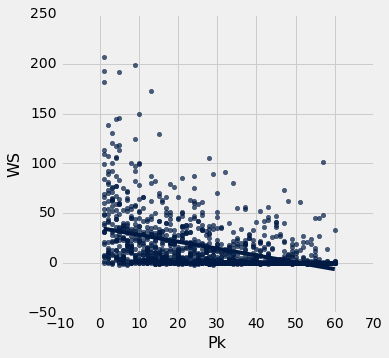

In [10]:
win_shares.select(['Pk', 'WS']).scatter('Pk', overlay=True, fit_line=True)
# plt.scatter(win_shares.column('Pk'), np.log(win_shares.column('WS')))
# plt.ylim((-3, 3))
plt.show()

This graph shows a clear correlation between a player's draft position (x-axis) and their normalized WS/48, although the data does seem to be noisy across all draft picks.

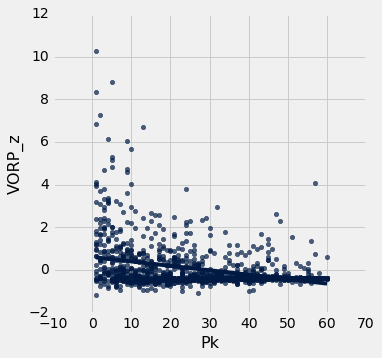

In [11]:
win_shares.select(['Pk', 'VORP_z']).scatter('Pk', overlay=True, fit_line=True)

Just double checking with VORP instead WS/48. There is indeed a correlation and a player's draft position. 

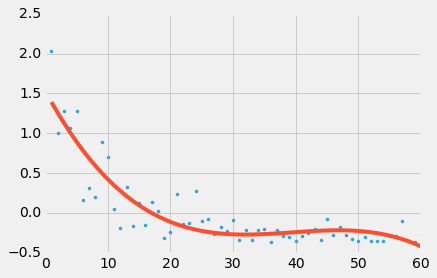

In [12]:
plt.plot(x, y, '.', xp, p(xp))
plt.show()

I use a polynomial regression to fit the scatter plot of the average of WS/48 or VORP at each draft pick over the years.

### Spurs

In [13]:
spurs = draft_data.where('Tm', 'SAS').join('Player', win_shares_2011)

ws = spurs.column(value_stat)
ws[ws == ''] = 0
spurs[value_stat] = ws.astype(np.float)

pk = spurs.apply(to_int, 'Pk')
spurs['Pk'] = pk.astype(np.int)

# spurs['WS/48_%'] = spurs.column('WS/48') / spurs.column('WS/48 sum')
# spurs['WS/48_z'] = (spurs.column('WS/48') - u) / stdev

# spurs.sort(value_stat + '_z', descending=True).show(10)

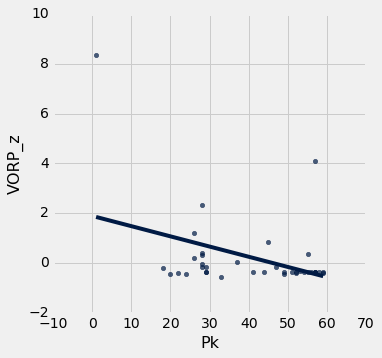

In [14]:
spurs.select(['Pk', value_stat + '_z']).scatter('Pk', overlay=True, fit_line=True)

The above plot shows only the Spurs' draft selections from 1991 through 2011. We don't evaluate data past 2011 because many draft picks don't contribute at their potential for around five years of development in the league. Notice that the Spurs rarely pick near the top of the draft. This is because the order of the draft is roughly the reverse order of the previous season's standings.

In [15]:
not_spurs = draft_data.where( \
    draft_data.column('Tm') \
    != 'SAS').join('Player', win_shares_2011) 

pk = not_spurs.apply(to_int, 'Pk')
not_spurs['Pk'] = pk.astype(np.float)

ws = not_spurs.column(value_stat)
ws[ws == ''] = 0
not_spurs[value_stat] = ws.astype(np.float)

# not_spurs[value_stat + '_%'] = not_spurs.column(value_stat) / not_spurs.column(value_stat + ' sum')
# not_spurs[value_stat + '_z'] = (not_spurs.column(value_stat) - u) / stdev
# not_spurs.show(1)

spurs_z_avg = sum(spurs.column(value_stat + '_z_ae')) / len(spurs.column(value_stat + '_z_ae'))
not_spurs_z_avg = sum(not_spurs.column(value_stat + '_z_ae')) / len(not_spurs.column(value_stat + '_z_ae'))
everyone_z_avg = sum(win_shares_2011.column(value_stat + '_z_ae')) / len(win_shares_2011.column(value_stat + '_z_ae'))
spurs_vs_everyone = Table(['Team', value_stat + '_z_ae']).with_rows([
    ["Spurs", spurs_z_avg],
    ["Everyone", not_spurs_z_avg]
])
spurs_vs_everyone


Team,VORP_z_ae
Spurs,0.438281
Everyone,0.04501


`VORP_z_ae` stands for normalized VORP above expected VORP based on draft position. We see that the Spurs do have a higher value for this stat. Is it statistically significant? We will proceed with a permutation test.

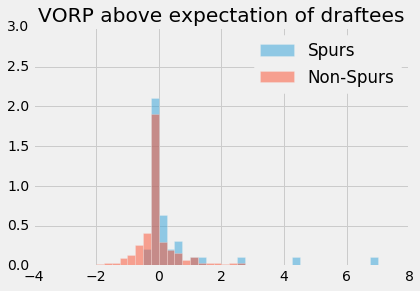

In [16]:
def plot_ws_z_ae(table1, table2, subject):
    spurs_draftees = table1.column(value_stat + '_z_ae') 
    non_spurs_draftees = table2.column(value_stat + '_z_ae') 
    
    plt.hist(spurs_draftees, alpha=.5, normed=True, label='Spurs', bins=np.arange(-4, 8, .25))
    plt.hist(non_spurs_draftees, alpha=.5, normed=True, label='Non-Spurs', bins=np.arange(-4, 8, .25))
    plt.legend(loc='upper right')
    plt.title(value_stat + " above expectation of " + subject)
    plt.ylim(0, 3)
    plt.show()

plot_ws_z_ae(spurs, not_spurs, 'draftees')


It's quite interesting to see that the Spurs have drafted a large proportion of players who did not meet their expectations based on their draft pick. At the same time, look above 1 and 2 on the x-axis: the Spurs drafted a larger proportion of players who exceeded or far exceeded their expectation.


In [17]:
career = win_shares_2011.pivot('Spurs', 'Career Status')
proportions = Table().with_columns([
        "Career Status", career.column("Career Status"),
        "Spurs", career.column('True')/sum(career.column('True')),
        "Non-Spurs", career.column('False')/sum(career.column('False'))
    ])
proportions.show()

Career Status,Spurs,Non-Spurs
Bad,0.0526316,0.0816327
Bust,0,0.0238095
Exceeded,0.342105,0.140306
Far Exceeded,0.0263158,0.0042517
Met,0.578947,0.75


I created a contingency table with five different Career Status categories that were defined when pre-processing the data.

In [18]:
# test_statistic = sum of the difference between two percentage for each category"
s = proportions.column('Spurs')
ns = proportions.column('Non-Spurs')
def test_statistic(s, ns):
    return (s[4] - ns[4]) + (s[3] - ns[3]) + (s[2] - ns[2]) + (ns[1] - s[1]) + (ns[0] - s[0])
    
observed_statistic = test_statistic(s, ns)
observed_statistic

0.10562119584675979

Career Status (shuffled),False,True
Bad,97,1
Bust,26,2
Exceeded,171,7
Far Exceeded,6,0
Met,876,28


0.0

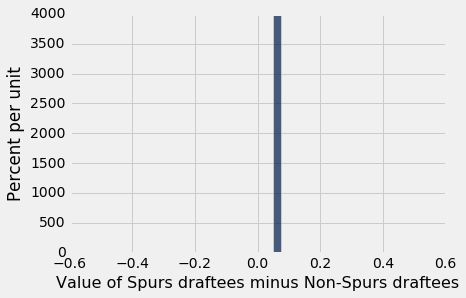

In [19]:
repetitions = 1

tvds = Table().with_column("Value of Spurs draftees minus Non-Spurs draftees", [])

for i in np.arange(repetitions):
    # Construct a permuted table
    shuffled = win_shares_2011.select('Career Status').sample()
    # Construct a table in which career status has been shuffled
    players_with_shuffled_career = Table().with_columns([
        "Spurs", win_shares_2011.column('Spurs'),
        "Career Status", win_shares_2011.column('Career Status'),
        "Career Status (shuffled)", shuffled.column('Career Status')
    ])
    career_shuffled = players_with_shuffled_career.pivot('Spurs', 'Career Status (shuffled)')
    career_shuffled.show()
    
    # Compute TVD
    c_s = career_shuffled
    s = c_s.column('True')/sum(c_s.column('True'))
    ns = c_s.column('False')/sum(c_s.column('False'))
    tvds.append([test_statistic(s, ns)])

tvds.hist(bins=np.arange(-0.5, 0.5, 0.025))

# tvds.show()

empirical_p_value = np.count_nonzero(tvds.column(0) >= observed_statistic) / tvds.num_rows
empirical_p_value

## Conclusion:  do the Spurs consistently draft better players?
---
Our p-value is not that low! Just 0.108 in this case. Although it appears visually that the Spurs draft significantly better than the rest of the NBA, a permutation test shows that the amount the Spurs are better is not statistically significant.



In this case, we need to take a look at underlying structure in the data that is not purely quantitative. 

#### Spurs draft strategy
--- 
With such success every season, the Spurs are never really looking for players who can change the face of the franchise immediately. Many current players were groomed in the Spurs system for a few years post-draft. The Spurs cleverly found a way around this constraint. They draft many European players, for which there is almost no risk! They are "stashed" away in Europe until they are likely ready to become a contributor, then they come across the pond and sign their contract and play. The key fact is that the Spurs do not pay the salaries of the "stashed" away players. This is the same reason we see that bin below z=0 filled with many Spurs players -- they simply never made it to the NBA.

With this taken into account with the low, but not that low, p-value, I conclude that it's safe to say that the Spurs do in fact have the unique ability to draft players who end up exceeding expectations.

### How about the other teams?


In [19]:
franchise_wins = Table.read_table('data/leagues_NBA_wins_active.csv')

for i in range(0, len(list(franchise_wins.labels)[3:])):
    col = franchise_wins.columns[3:][i]
    col = np.nan_to_num(col)
    
    zero_indexes = []
    for j in range(0, len(col)):
        w = col[j]
        if w == 0:
            zero_indexes.append(j)
        
    if len(zero_indexes) != 0:
#         print(zero_indexes)
        after = col[min(zero_indexes)-1]
        before = after
        if max(zero_indexes)+1 < len(col):
            before = col[max(zero_indexes)+1]
        avg_wins = (after + before) / 2
        col[col == 0] = avg_wins
    
    col_name = list(franchise_wins.labels)[3:][i]
    franchise_wins[col_name] = col

            

In [20]:
from scipy import stats

teams = win_shares_2011.sort('Tm').group('Tm', np.mean).select(['Tm', value_stat + '_z_ae mean']).sort(value_stat + '_z_ae mean', descending=True)
team_wins = []

for team in teams.column('Tm'):
    wins = sum(franchise_wins.column(team)[1:21])
#     wins = sum([1 if season >= 60 else 0 for season in franchise_wins.column(team)[1:21]])
    team_wins.append(wins)
    
teams['wins'] = team_wins 
teams.show()


Tm,VORP_z_ae mean,wins
SAS,0.445865,1084
NOP,0.395924,827
PHO,0.33389,894
CLE,0.322206,765
LAL,0.202778,979
HOU,0.141909,891
OKC,0.13902,895
BOS,0.116992,784
DET,0.10996,835
ORL,0.107054,809


The Spurs had the  most success drafting players that exceeded expectations.

0.50528766478721454

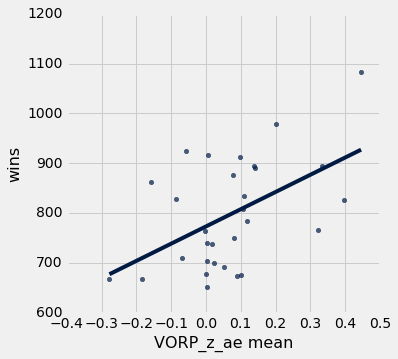

In [21]:
teams.select([value_stat + '_z_ae mean', 'wins']).scatter(value_stat + '_z_ae mean', overlay=True, fit_line=True)
r = np.corrcoef(teams.column(1), teams.column(2))[1,0]
r

We find that drafting players who exceed expectations is a decent indicator for wins. There definitely is a positive correlation, although drafting players is merely a small part in running a successful team. 

## Draft Adage \#2
### Big men who are too skinny as prospects are more likely to fail
---
A common knock against young big men entering the NBA is that they are too weak, too skinny, to compete with the grown men who dominate the league.

Here are a few excerpts of scouting reports on some of this year's big men:
- "Stronger players can bully him on the post on both ends of the floor … Has to bulk up to play at the next level, and appears to have a naturally skinny bodytype" - about Dragan Bender
- "Lacks muscle and weight for his position" - about Zhou Qi
- "Lacks lower body strength and not clear how much he can continue to fill out with his very narrow frame" - about YouTube mixtape phenom and aspiring NBA player Thon Maker

Clearly this is an attribute that teams take into serious consideration. How well did previous big men fare?

In [36]:
bigs_a = anthro_data.where("POSITION", "C")
bigs_a.append(anthro_data.where("POSITION", "PF-C"))
bigs_a.append(anthro_data.where("POSITION", "PF"))

joined_bigs_table = bigs_a.join('PLAYER_NAME', win_shares, 'Player').join('PLAYER_NAME', draft_data, 'Player')
joined_bigs_table.where(joined_bigs_table["BMI"] < (np.mean(joined_bigs_table['BMI']) - np.std(joined_bigs_table['BMI'])))

ws = joined_bigs_table.column('WS/48')
ws[ws == ''] = 0
joined_bigs_table['WS/48'] = ws.astype(np.float)
vorp = joined_bigs_table.column('VORP')
vorp[vorp == ''] = 0
joined_bigs_table['VORP'] = vorp.astype(np.float)

joined_bigs_table.show(1)

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:12: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future


PLAYER_NAME,Year,TEMP_PLAYER_ID,PLAYER_ID,FIRST_NAME,LAST_NAME,POSITION,HEIGHT_WO_SHOES,HEIGHT_WO_SHOES_FT_IN,HEIGHT_W_SHOES,HEIGHT_W_SHOES_FT_IN,WEIGHT,WINGSPAN,WINGSPAN_FT_IN,STANDING_REACH,STANDING_REACH_FT_IN,BODY_FAT_PCT,HAND_LENGTH,HAND_WIDTH,BMI,Pk,Year_2,Tm,WS/48,WS/48 sum,VORP,VORP sum,WS,WS/48_%,VORP_%,WS/48_z,VORP_z,WS/48_z mean,VORP_z mean,WS/48_z_expected,VORP_z_expected,WS/48_z_ae,VORP_z_ae,Career Status,Spurs,Year_3,Rk,Pk_2,Tm_2,College,Yrs,G,MP,PTS,TRB,AST,FG%,3P%,FT%,MPPG,PPG,RPG,APG,WS_2,WS/48_2,BPM,VORP_2
Aaron Gray,2007,,201189,Aaron,Gray,C,84.0,7' 0'',85.75,7' 1.75'',271,87.25,7' 3.25'',108.5,9' 0.5'',10.8,,,27.0001,49,2007,CHI,0,3.081,0,201.8,6.2,0.0249919,0.00099108,0.263403,-0.33745,-0.339197,-0.328076,-0.276783,-0.221361,0.540186,-0.116089,Met,False,2007,49,49,CHI,University of Pittsburgh,7,318,3851,1066,1190,207,.509,.000,.562,12.1,3.4,3.7,0.7,6.2,.077,-1.8,0.2


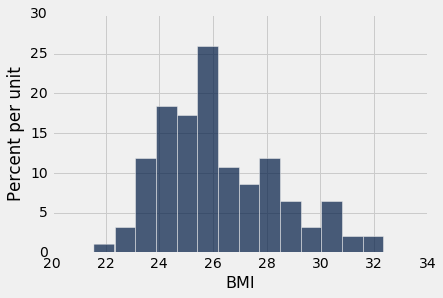

In [32]:
joined_bigs_table.hist(select="BMI", \
    bins=np.arange(np.min(joined_bigs_table["BMI"]), \
    np.max(joined_bigs_table["BMI"]), np.std(joined_bigs_table['BMI'])/3))

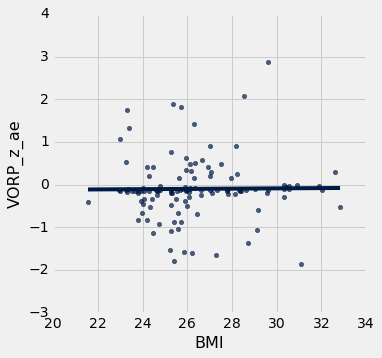

In [33]:
joined_bigs_table.scatter("BMI", "VORP_z_ae", fit_line=True)

## Conclusion: Skinny big men did no worse than their bulkier counterparts
---
As we can see in this scatter plot, there is no correlation between a big man's BMI when entering the NBA and how their career pans out. This is good news for aspiring NBA players who are on the skinny side, such as Cal's very own Ivan Rabb (whenever he declares for the draft). 


It is however interesting to note that no big with BMI > 28 failed to at least play in the NBA. This fits into the narrative that bulkier players are "pro-ready" while skinnier ones are more boom or bust.

## Adage \#3
### Big men have shorter careers
---
Yao Ming might be one of the NBA's biggest "what if" players. Just as he became a dominant player, foot injuries derailed his career and forced an early retirement.  Around that time, the number 1 overall pick Greg Oden quickly fell out of the NBA after two major knee injuries. The media narrative developed that big men were more likely to have severe injury woes, especially in the feet. Is it true?

In [40]:
joined_bigs_table['Big'] = True
joined_bigs_table = joined_bigs_table.select(['PLAYER_NAME', 'Year', 'Yrs', 'G', 'MP', 'Big']).sort('Yrs')


In [41]:
others = anthro_data.where("POSITION", "PG")
others = anthro_data.where("POSITION", "PG-SG")
others.append(anthro_data.where("POSITION", "SG"))
others.append(anthro_data.where("POSITION", "SG-SF"))
others.append(anthro_data.where("POSITION", "SF"))
others.append(anthro_data.where("POSITION", "SF-PF"))

joined_others_table = others.join('PLAYER_NAME', draft_data, 'Player')
joined_others_table['Big'] = False
joined_others_table = joined_others_table.select(['PLAYER_NAME', 'Year', 'Yrs', 'G', 'MP', 'Big'])

joined_others_table

PLAYER_NAME,Year,Yrs,G,MP,Big
A.J. Guyton,2000,3,80,1246,False
Adam Morrison,2006,3,161,3278,False
Al Thornton,2007,4,296,8274,False
Al-Farouq Aminu,2010,6,459,10747,False
Alec Burks,2011,5,259,5965,False
Alex Acker,2005,2,30,234,False
Andre Emmett,2004,2,14,73,False
Andre Iguodala,2004,12,900,31836,False
Andy Rautins,2010,1,5,24,False
Antonis Fotsis,2000,1,28,320,False


In [42]:
yrs = joined_bigs_table.column('Yrs')
yrs[yrs == ''] = 0
joined_bigs_table['Yrs'] = yrs.astype(np.float)

mp = joined_bigs_table.column('MP')
mp[mp == ''] = 0
joined_bigs_table['MP'] = mp.astype(np.float)

g = joined_bigs_table.column('G')
g[g == ''] = 0
joined_bigs_table['G'] = g.astype(np.float)



yrs = joined_others_table.column('Yrs')
yrs[yrs == ''] = 0
joined_others_table['Yrs'] = yrs.astype(np.float)

mp = joined_others_table.column('MP')
mp[mp == ''] = 0
joined_others_table['MP'] = mp.astype(np.float)

g = joined_others_table.column('G')
g[g == ''] = 0
joined_others_table['G'] = g.astype(np.float)

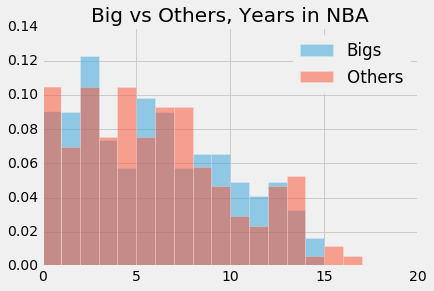

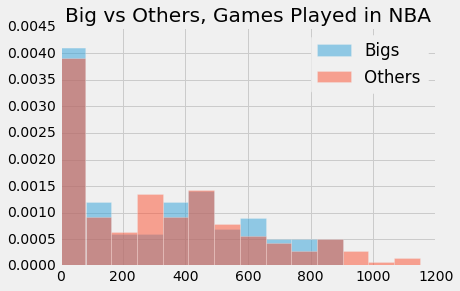

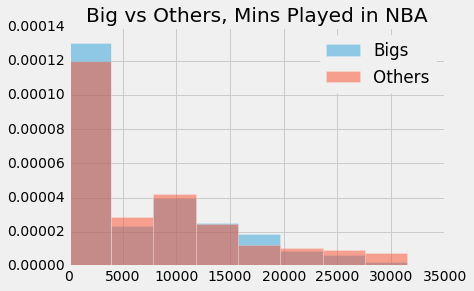

In [43]:
big_yrs = joined_bigs_table.column('Yrs')
others_yrs = joined_others_table.column('Yrs')

plt.hist(big_yrs, alpha=.5, normed=True, label='Bigs', bins=range(0,20,1))
plt.hist(others_yrs, alpha=.5, normed=True, label='Others', bins=range(0,20,1))
plt.legend(loc='upper right')
plt.title('Big vs Others, Years in NBA')
plt.show()

big_gp = joined_bigs_table.column('G')
others_gp = joined_others_table.column('G')

plt.hist(big_gp, alpha=.5, normed=True, label='Bigs', bins=range(0,1200,82))
plt.hist(others_gp, alpha=.5, normed=True, label='Others', bins=range(0,1200,82))
plt.legend(loc='upper right')
plt.title('Big vs Others, Games Played in NBA')
plt.show()

big_mins = joined_bigs_table.column('MP')
others_mins = joined_others_table.column('MP')

plt.hist(big_mins, alpha=.5, normed=True, label='Bigs', bins=range(0,35000,3936))
plt.hist(others_mins, alpha=.5, normed=True, label='Others', bins=range(0,35000,3936))
plt.legend(loc='upper right')
plt.title('Big vs Others, Mins Played in NBA')
plt.show()

observed: -0.038982081586
p-value: 0.634
observed: -0.0273541746092
p-value: 0.698
observed: -0.0345024780785
p-value: 0.678


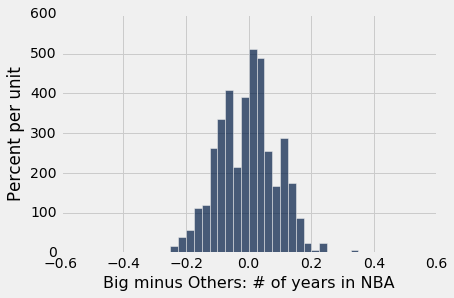

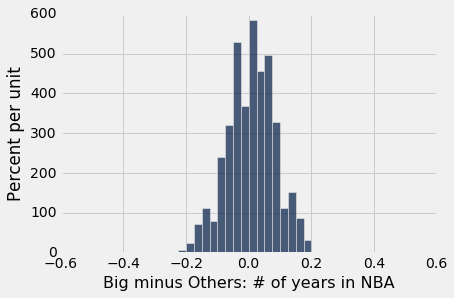

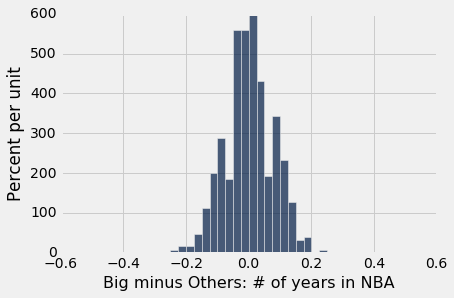

In [44]:
def adage_3_test_statistic(bigs, others):
    return sum(bigs[:5] - others[:5]) + sum(others[10:] - bigs[10:])

combined = joined_bigs_table.append(joined_others_table)

def permutation_test(label):
    yrs = combined.pivot('Big', label)
    proportions = Table().with_columns([
            label, yrs.column(label),
            "Big", yrs.column('True')/sum(yrs.column('True')),
            "Other", yrs.column('False')/sum(yrs.column('False'))
        ])

    a = proportions.column('Big')
    b = proportions.column('Other')

    observed_statistic = adage_3_test_statistic(a, b)
    print('observed: ' + str(observed_statistic))


    repetitions = 500

    tvds = Table().with_column("Big minus Others: # of years in NBA", [])

    for i in np.arange(repetitions):
        # Construct a permuted table
        shuffled = combined.select(label).sample()
        # Construct a table in which career status has been shuffled
        players_with_shuffled_yrs = Table().with_columns([
            "Big", combined.column('Big'),
            label, combined.column(label),
            label + " (shuffled)", shuffled.column(label)
        ])

        yrs_shuffled = players_with_shuffled_yrs.pivot('Big', label + ' (shuffled)')

        # Compute TVD
        y_s = yrs_shuffled
        bigs = y_s.column('True')/sum(y_s.column('True'))
        others = y_s.column('False')/sum(y_s.column('False'))
        tvds.append([adage_3_test_statistic(bigs, others)])

    tvds.hist(bins=np.arange(-0.5, 0.5, 0.025))

    # tvds.show()

    empirical_p_value = np.count_nonzero(tvds.column(0) >= observed_statistic) / tvds.num_rows
    print('p-value: ' + str(empirical_p_value))

    
for label in ['Yrs', 'G', 'MP']:
    permutation_test(label)

## Conclusion: Big men have similar career lengths as non-big men!
---
The media narrative was incorrect. It seems that there was selection bias which caused the narrative to develop. In reality, the numbers tell us that big men and non-big men have no difference in career lengths, in terms of years played, games played, and minutes played

###### Thanks :) - Canzhi Ye